In [1]:
import pandas as pd

In [2]:
with pd.ExcelFile("../data/momentum_data.xlsx") as xls:  
    mom_factor = pd.read_excel(xls, sheet_name="momentum (excess returns)", index_col="Date").iloc[:, 0]
    ff3_factors = pd.read_excel(xls, sheet_name="factors (excess returns)", index_col="Date")
    mom_decile = pd.read_excel(xls, sheet_name="deciles (total returns)", index_col="Date")
    mom_size = pd.read_excel(xls, sheet_name="size_sorts (total returns)", index_col="Date")
    rf = pd.read_excel(xls, sheet_name="risk-free rate", index_col="Date").iloc[:, 0]

In [3]:
# 1.
def performance_stat(s: pd.Series) -> pd.Series:
    """
    Calculate the mean, volatility, sharpe of given series
    
    Parameters:
        s (pd.Series): 
            Excess return of certain asset / portfolio
            Index: all time period (i.e. monthly)
            
    Returns:
        s_stat: Series contains mean, volatility, sharpe of the input series
    """
    s_stat = s.agg(['mean', 'std', 'skew']).T
    s_stat['mean'] *= 12
    s_stat['std'] *= (12 ** (1/2))
    s_stat['sharpe'] = s_stat['mean'] / s_stat['std']
    corr = pd.concat([s, ff3_factors.loc[s.index]], axis=1).corr()
    s_stat['corr_mkt'] = corr.loc['MKT', 'UMD']
    s_stat['corr_value'] = corr.loc['HML', 'UMD']
    return s_stat

momentum_ff = ((mom_size['SMALL HiPRIOR'] + mom_size['BIG HiPRIOR']) / 2 - 
               (mom_size['SMALL LoPRIOR'] + mom_size['BIG LoPRIOR']) / 2).rename('UMD')

df_stat = pd.DataFrame({
    '1927_2023': performance_stat(momentum_ff),
    '1927-1993': performance_stat(momentum_ff.loc[:'1993']),
    '1993-2008': performance_stat(momentum_ff.loc['1994':'2008']),
    '2009-2023': performance_stat(momentum_ff.loc['2009':'2023']),
})
df_stat.T

,mean,std,skew,sharpe,corr_mkt,corr_value
1927_2023,0.074761,0.163066,-2.992276,0.458473,-0.346319,-0.404795
1927-1993,0.090075,0.159987,-3.809269,0.563018,-0.362513,-0.494935
1993-2008,0.104327,0.175548,-0.582412,0.594291,-0.234513,-0.129356
2009-2023,-0.026006,0.161625,-2.697760,-0.160902,-0.385521,-0.309242


(b)
From 1927-1993 to 1993-2009, momentum's mean, sharpe, and the correlation with both market and value increases slightly.
From 1993-2009 to 2009-2023, momentum's mean and sharpe decreases dramatically. The correlation with both market and value also decreases.
The volatility has no big changes across different periods.

(c)
Yes. Because the mean return are positive on average over the entire sample period and momentum's correlation with market and value are negative. 

In [4]:
# 2.
momentum_uff = ((mom_size['SMALL HiPRIOR'] + mom_size['BIG HiPRIOR']) / 2 - rf).rename('UMD')

df_stat_size = pd.DataFrame({
    'long-short': performance_stat(momentum_ff.loc['1994':'2023']),
    'long': performance_stat(momentum_uff.loc['1994':'2023']),
}).T
df_stat_size

,mean,std,skew,sharpe,corr_mkt,corr_value
long-short,0.040078,0.169639,-1.437502,0.236256,-0.313551,-0.206171
long,0.115447,0.178350,-0.463528,0.647306,0.901697,-0.130850


(b) Yes. Long only has higher mean and sharpe ratio. 
(c) No. Long only has very high correlation (>0.9) with market factor. But both long and long-short portfolio has negative correlation with value factor, though long only portfolio is higher.

<Axes: title={'center': 'Cumulative Product'}, xlabel='Date'>

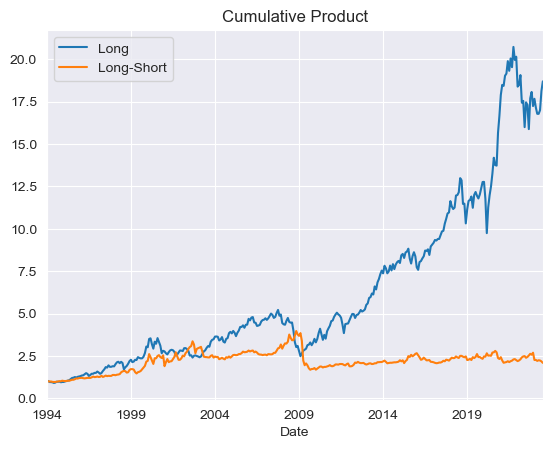

In [5]:
(pd.concat([momentum_uff.loc['1994':'2023'].rename('Long'), 
            momentum_ff.loc['1994':'2023'].rename('Long-Short')], axis=1) + 1).cumprod().plot(title="Cumulative Product")

In [6]:
# 3.
momentum_d1 = (mom_decile['Hi PRIOR'] - mom_decile['Lo PRIOR']).rename('UMD')
momentum_d3 = (mom_decile.iloc[:, -3:].mean(axis=1) - mom_decile.iloc[:, :3].mean(axis=1)).rename('UMD')
momentum_d5 = (mom_decile.iloc[:, -5:].mean(axis=1) - mom_decile.iloc[:, :5].mean(axis=1)).rename('UMD')

df_stat_decile = pd.DataFrame({
    'top-1': performance_stat(momentum_d1.loc['1994':'2023']),
    'top-3': performance_stat(momentum_d3.loc['1994':'2023']),
    'top-5': performance_stat(momentum_d5.loc['1994':'2023']),
}).T
df_stat_decile

,mean,std,skew,sharpe,corr_mkt,corr_value
top-1,0.074873,0.298583,-1.307240,0.250762,-0.329943,-0.214096
top-3,0.024814,0.194199,-1.350529,0.127774,-0.370049,-0.194311
top-5,0.013016,0.134476,-1.428013,0.096792,-0.359342,-0.194664


(b) Yes. Both the mean returns and the volatility are ranked by 1-decile > 3-decile > 5-decile. 1-decile has the highest returns from the most concentrated portfolio and therefore contains higher idiosyncratic risk, i.e. highest volatility.

(c) 1-decile. Because 1-decile has the better sharpe ratio. 

In [7]:
# 3.(d)
pd.concat([
    df_stat_size.iloc[0, :],
    df_stat_decile.iloc[1, :]
], axis=1).T

,mean,std,skew,sharpe,corr_mkt,corr_value
long-short,0.040078,0.169639,-1.437502,0.236256,-0.313551,-0.206171
top-3,0.024814,0.194199,-1.350529,0.127774,-0.370049,-0.194311


(d) No. There are quite noticeable differences between all stats of the two portfolio. This could be attribute to the fact that we are ignoring the returns of middle size stocks when constructing long-short portfolio in table 2.

In [8]:
# 4.
momentum_small =(mom_size['SMALL HiPRIOR'] - mom_size['SMALL LoPRIOR']).rename('UMD')
momentum_big =(mom_size['BIG HiPRIOR'] - mom_size['BIG LoPRIOR']).rename('UMD')

pd.DataFrame({
    'all': performance_stat(momentum_ff.loc['1994':'2023']),
    'small': performance_stat(momentum_small.loc['1994':'2023']),
    'big': performance_stat(momentum_big.loc['1994':'2023']),
}).T

,mean,std,skew,sharpe,corr_mkt,corr_value
all,0.040078,0.169639,-1.437502,0.236256,-0.313551,-0.206171
small,0.059358,0.171924,-1.744008,0.345256,-0.309153,-0.146270
big,0.020799,0.183927,-0.877121,0.113082,-0.289410,-0.243587


(b) Yes. Small stocks momentum portfolio has much higher mean return and sharpe ratio. Although big stock portfolio's sharpe ratio is less than optimal, it's noticeable that it still has quite negative correlation with market and value factor (for value, it's even more negative than small portfolio). This means big stock portfolio has value in diversification.

In [9]:
# 5
pd.DataFrame({
    'factor': performance_stat(mom_factor.loc['1994':'2023']),
    'ff3': performance_stat(momentum_ff.loc['1994':'2023']),
}).T

,mean,std,skew,sharpe,corr_mkt,corr_value
factor,0.040090,0.169641,-1.437432,0.236324,-0.313551,-0.206254
ff3,0.040078,0.169639,-1.437502,0.236256,-0.313551,-0.206171


Conclusion: 
Yes. All stats are very similiar between AQR product and ff3 constructed momentum. 
Some modifications:
- AQR could use select less stocks from top and bottom, e.g. top 1 decile, when constructing long-short portfolio. As shown in table 4, it could deliver higher sharpe ratio. 